In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.inspection import permutation_importance
import joblib

In [87]:
df = pd.read_csv('/content/Insurance.csv')
df.head()

,Customer_ID,Age,Gender,Marital_Status,Dependents,Location,Income,Profession,Existing_Savings,Premium,Policy_Type,Policy_Tenure,Claims_Count,Past_Claims_Amount,Smoking_Status,Chronic_Condition,BMI,Alcohol_Consumption,Exercise,Insurance_Status
0,1,38,Female,Married,0,Rural,81362,IT,114297,26060,Health,11,1,22977,Smoker,Yes,22.0,Yes,Regular,1
1,2,68,Male,Married,3,Urban,9363,Business,2811,18160,Life,0,0,0,Non-Smoker,No,23.8,No,Occasional,0
2,3,52,Male,Single,3,Urban,54462,Teacher,37360,21240,Health,7,0,0,Smoker,No,21.2,No,Occasional,1
3,4,46,Female,Married,2,Rural,31242,Labor,26639,20520,Health,14,0,0,Smoker,No,25.5,No,Occasional,0
4,5,30,Male,Single,1,Urban,20092,IT,6352,15600,Health,10,0,0,Non-Smoker,No,23.8,Yes,NaN,0


In [88]:
df.shape

(50000, 20)

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Customer_ID          50000 non-null  int64  
 1   Age                  50000 non-null  int64  
 2   Gender               50000 non-null  object 
 3   Marital_Status       50000 non-null  object 
 4   Dependents           50000 non-null  int64  
 5   Location             50000 non-null  object 
 6   Income               50000 non-null  int64  
 7   Profession           50000 non-null  object 
 8   Existing_Savings     50000 non-null  int64  
 9   Premium              50000 non-null  int64  
 10  Policy_Type          50000 non-null  object 
 11  Policy_Tenure        50000 non-null  int64  
 12  Claims_Count         50000 non-null  int64  
 13  Past_Claims_Amount   50000 non-null  int64  
 14  Smoking_Status       50000 non-null  object 
 15  Chronic_Condition    50000 non-null 

In [90]:
df['Exercise'].fillna(df['Exercise'].mode()[0], inplace=True)
df.head()

/tmp/ipython-input-3118530873.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Exercise'].fillna(df['Exercise'].mode()[0], inplace=True)


,Customer_ID,Age,Gender,Marital_Status,Dependents,Location,Income,Profession,Existing_Savings,Premium,Policy_Type,Policy_Tenure,Claims_Count,Past_Claims_Amount,Smoking_Status,Chronic_Condition,BMI,Alcohol_Consumption,Exercise,Insurance_Status
0,1,38,Female,Married,0,Rural,81362,IT,114297,26060,Health,11,1,22977,Smoker,Yes,22.0,Yes,Regular,1
1,2,68,Male,Married,3,Urban,9363,Business,2811,18160,Life,0,0,0,Non-Smoker,No,23.8,No,Occasional,0
2,3,52,Male,Single,3,Urban,54462,Teacher,37360,21240,Health,7,0,0,Smoker,No,21.2,No,Occasional,1
3,4,46,Female,Married,2,Rural,31242,Labor,26639,20520,Health,14,0,0,Smoker,No,25.5,No,Occasional,0
4,5,30,Male,Single,1,Urban,20092,IT,6352,15600,Health,10,0,0,Non-Smoker,No,23.8,Yes,Occasional,0


In [91]:
df.drop('Customer_ID', axis=1, inplace=True)

In [92]:
df['Income_Premium_Ratio'] = df['Income'] / (df['Premium'] + 1)
df['Claim_Frequency'] = df['Claims_Count'] / (df['Policy_Tenure'] + 1)
df['Chronic_Condition_Num'] = df['Chronic_Condition'].map({'Yes':1,'No':0})
df['Risk_Score'] = 0.4*df['Age'] + 0.3*df['BMI'] + 0.3*df['Chronic_Condition_Num']*100

In [93]:
df.describe()

,Age,Dependents,Income,Existing_Savings,Premium,Policy_Tenure,Claims_Count,Past_Claims_Amount,BMI,Insurance_Status,Income_Premium_Ratio,Claim_Frequency,Chronic_Condition_Num,Risk_Score
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,43.782160,1.201440,41079.879620,32986.353540,18097.759200,9.464040,0.398360,15844.705520,25.082284,0.565860,2.351252,0.071995,0.198880,31.003949
std,13.062882,1.089993,21899.127584,25906.629988,3404.019343,5.756423,0.632295,32732.999921,3.824273,0.495648,1.349621,0.200442,0.399162,13.084967
min,18.000000,0.000000,4015.000000,606.000000,10160.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.232336,0.000000,0.000000,12.630000
25%,34.000000,0.000000,25843.500000,14438.750000,15640.000000,4.000000,0.000000,0.000000,22.300000,0.000000,1.422499,0.000000,0.000000,21.800000
50%,42.000000,1.000000,36178.000000,26680.500000,17880.000000,9.000000,0.000000,0.000000,25.000000,1.000000,2.037389,0.000000,0.000000,26.420000
75%,53.000000,2.000000,50716.750000,44015.250000,20280.000000,14.000000,1.000000,20448.750000,27.700000,1.000000,2.920618,0.071429,0.000000,34.090000
max,79.000000,5.000000,299444.000000,334752.000000,34180.000000,19.000000,5.000000,556952.000000,35.000000,1.000000,16.604496,4.000000,1.000000,70.900000


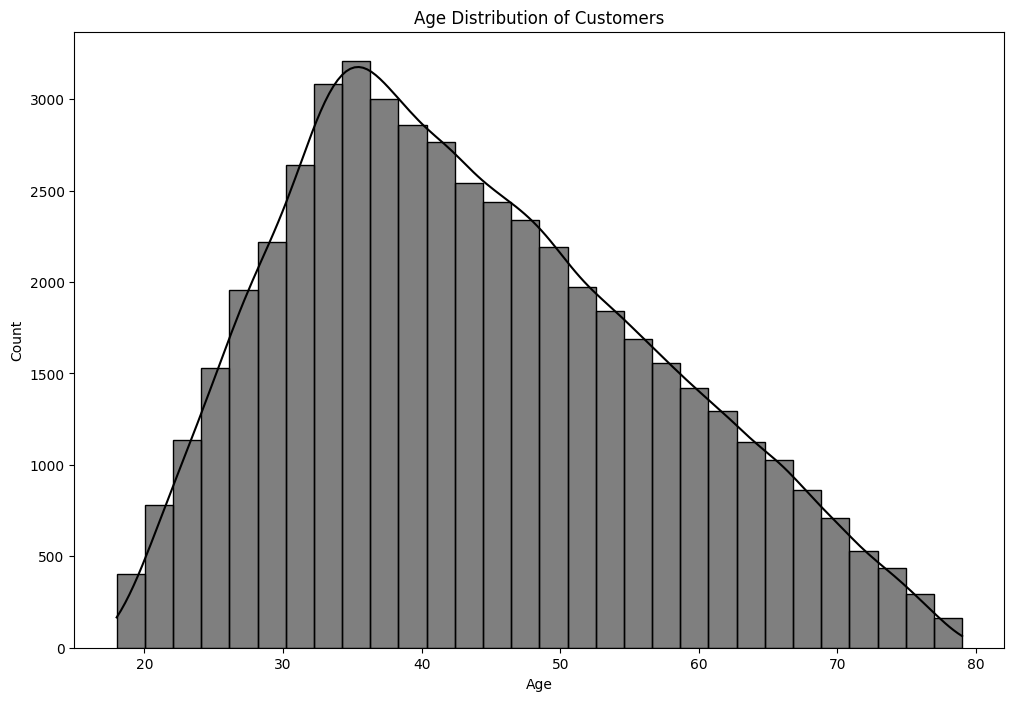

In [94]:
plt.figure(figsize=(12,8))
sns.histplot(df['Age'], bins=30, kde=True, color='black')
plt.title("Age Distribution of Customers")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

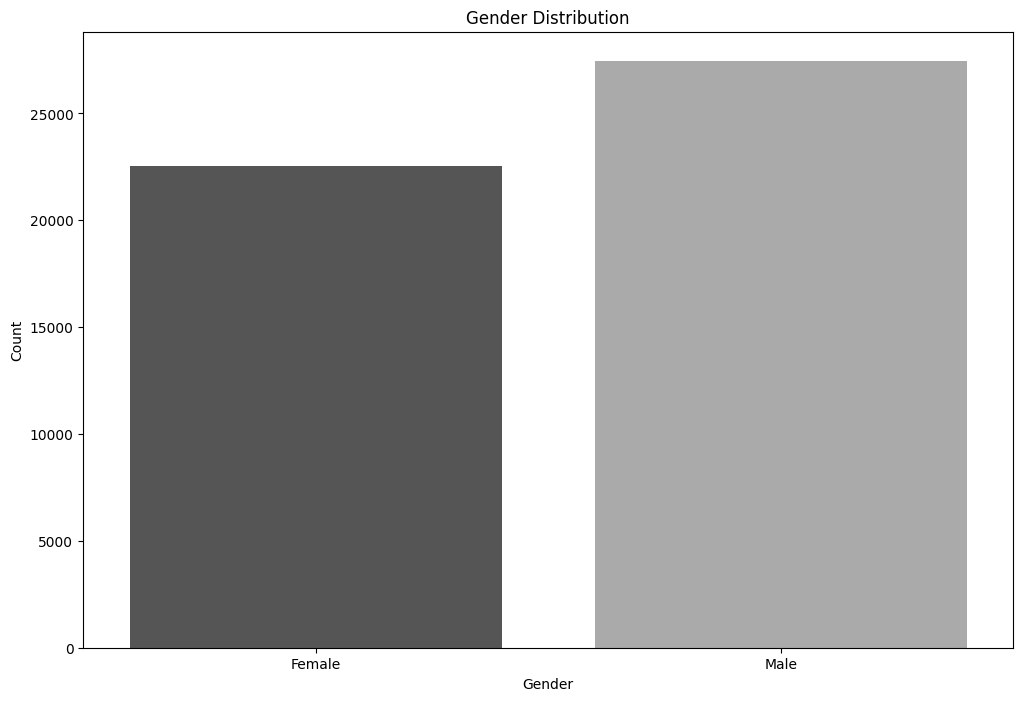

In [95]:
plt.figure(figsize=(12,8))
sns.countplot(x='Gender', data=df, hue='Gender', palette='gray')
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

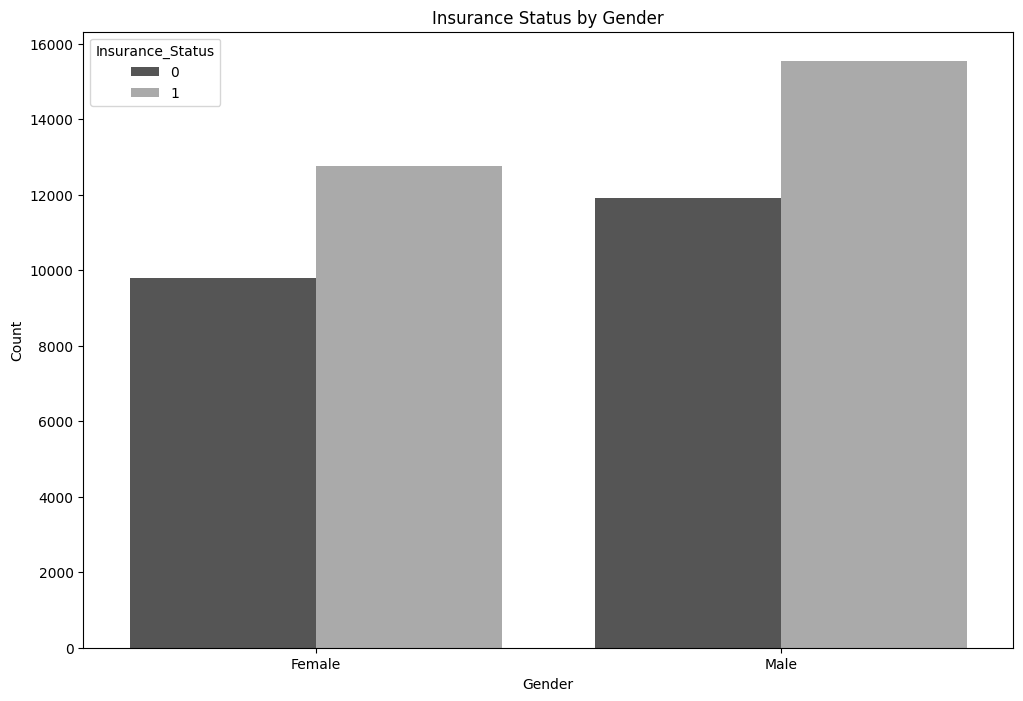

In [96]:
plt.figure(figsize=(12,8))
sns.countplot(x='Gender', hue='Insurance_Status', data=df, palette='gray')
plt.title("Insurance Status by Gender")
plt.ylabel("Count")
plt.show()

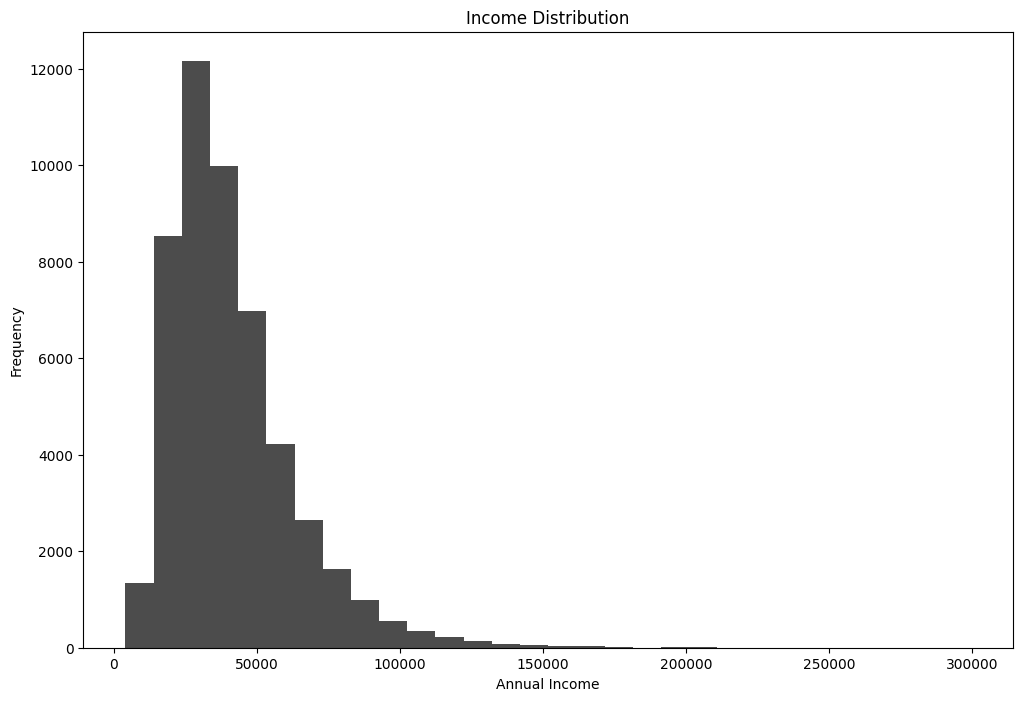

In [97]:
plt.figure(figsize=(12,8))
plt.hist(df['Income'], bins=30, color='black', alpha=0.7)
plt.title("Income Distribution")
plt.xlabel("Annual Income")
plt.ylabel("Frequency")
plt.show()

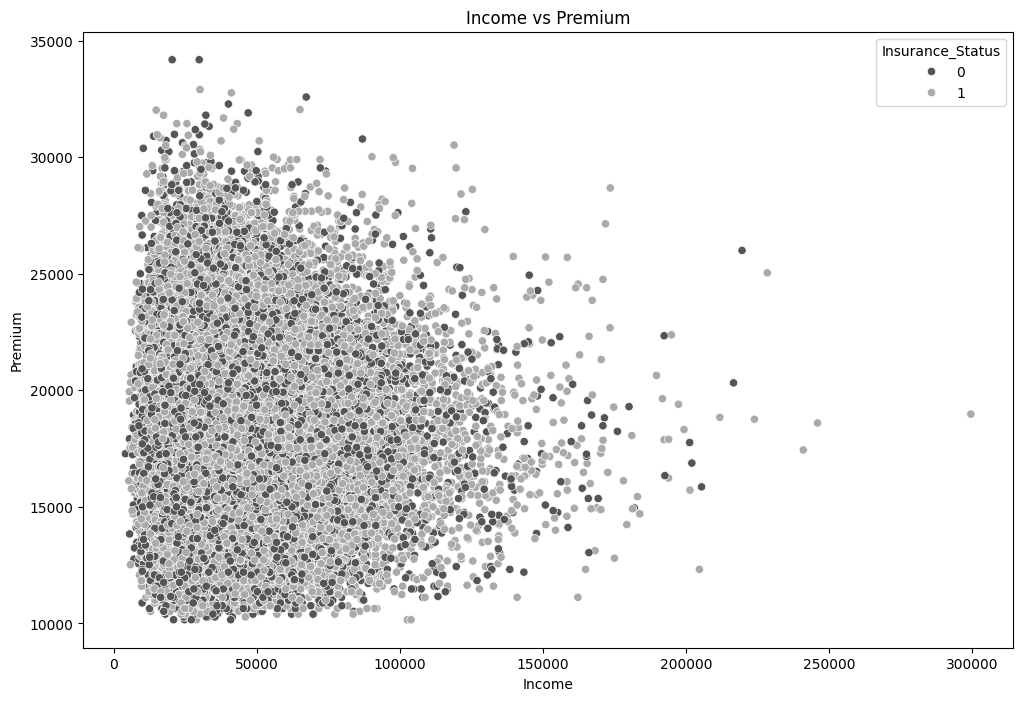

In [98]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='Income', y='Premium', hue='Insurance_Status', data=df, palette='gray')
plt.title("Income vs Premium")
plt.show()


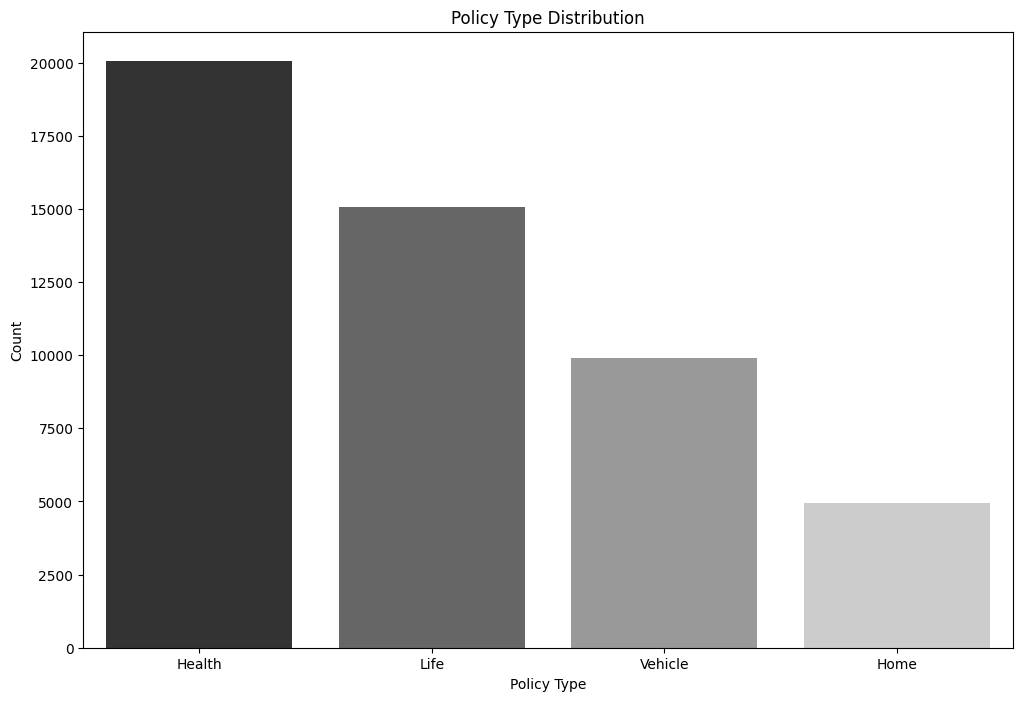

In [99]:
plt.figure(figsize=(12,8))
sns.countplot(x='Policy_Type', data=df, hue='Policy_Type', palette='gray')
plt.title("Policy Type Distribution")
plt.xlabel("Policy Type")
plt.ylabel("Count")
plt.show()


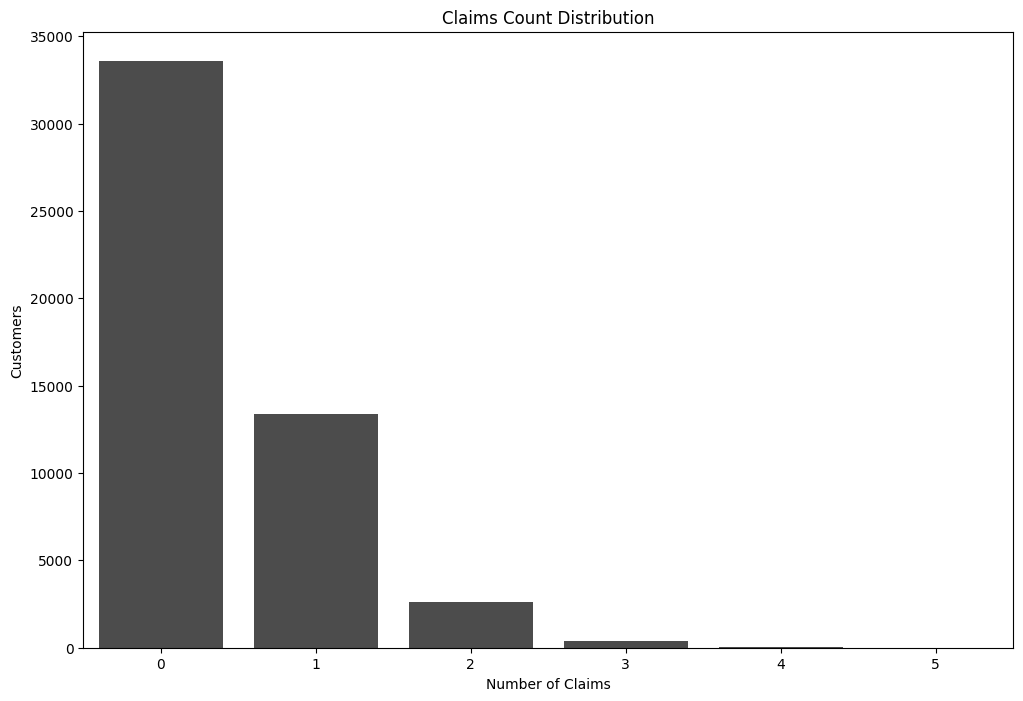

In [100]:
plt.figure(figsize=(12,8))
sns.countplot(x='Claims_Count', data=df, color='black', alpha=0.7)
plt.title("Claims Count Distribution")
plt.xlabel("Number of Claims")
plt.ylabel("Customers")
plt.show()

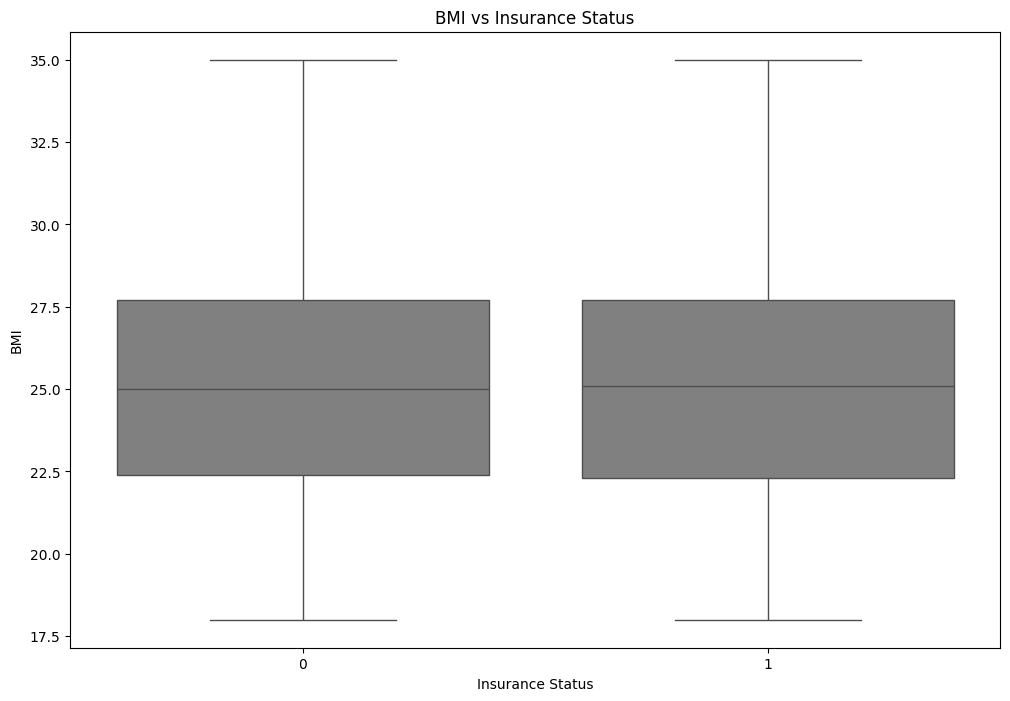

In [101]:
plt.figure(figsize=(12,8))
sns.boxplot(x='Insurance_Status', y='BMI', data=df, color='gray')
plt.title("BMI vs Insurance Status")
plt.xlabel("Insurance Status")
plt.ylabel("BMI")
plt.show()

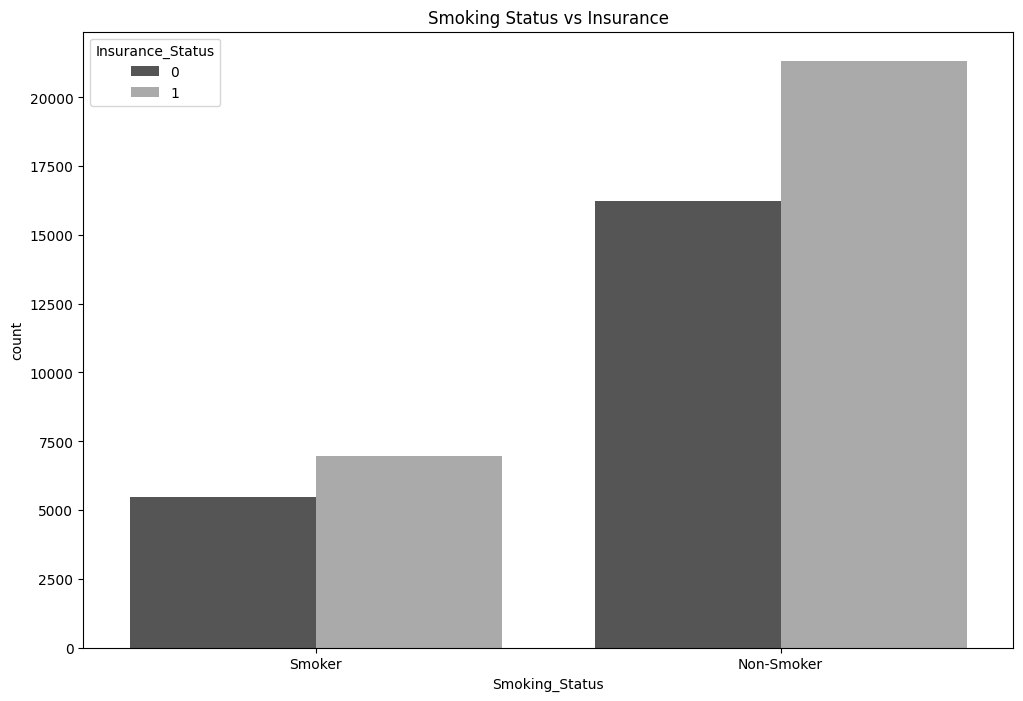

In [102]:
plt.figure(figsize=(12,8))
sns.countplot(x='Smoking_Status', hue='Insurance_Status', data=df, palette='gray')
plt.title("Smoking Status vs Insurance")
plt.show()

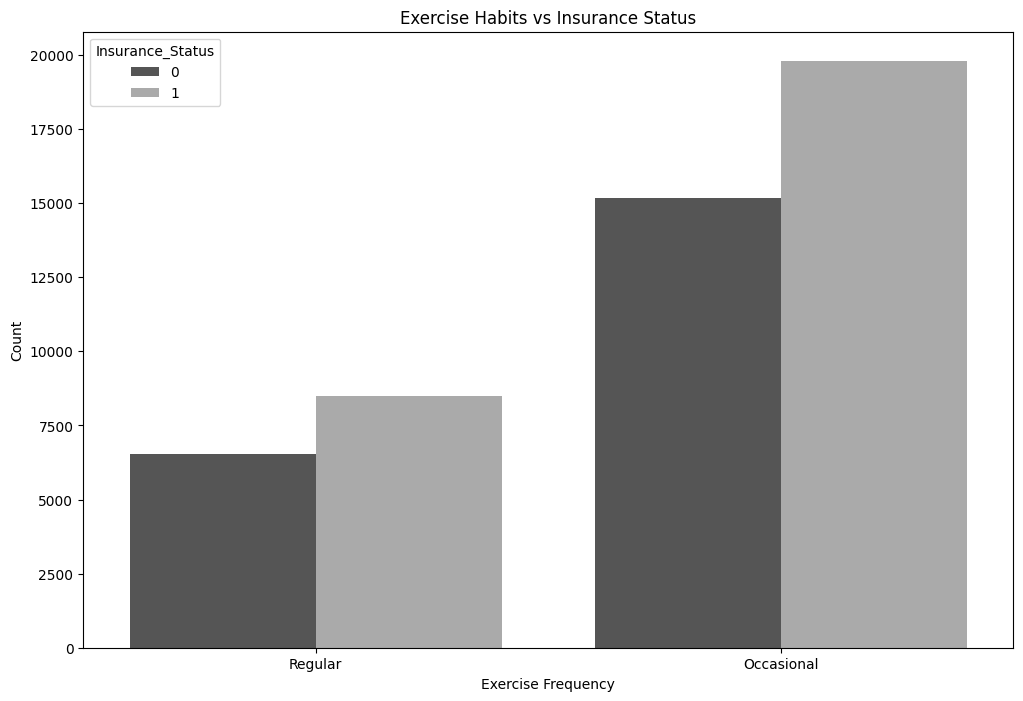

In [103]:
plt.figure(figsize=(12,8))
sns.countplot(x='Exercise',hue='Insurance_Status',data=df, palette='gray')
plt.title("Exercise Habits vs Insurance Status")
plt.xlabel("Exercise Frequency")
plt.ylabel("Count")
plt.show()

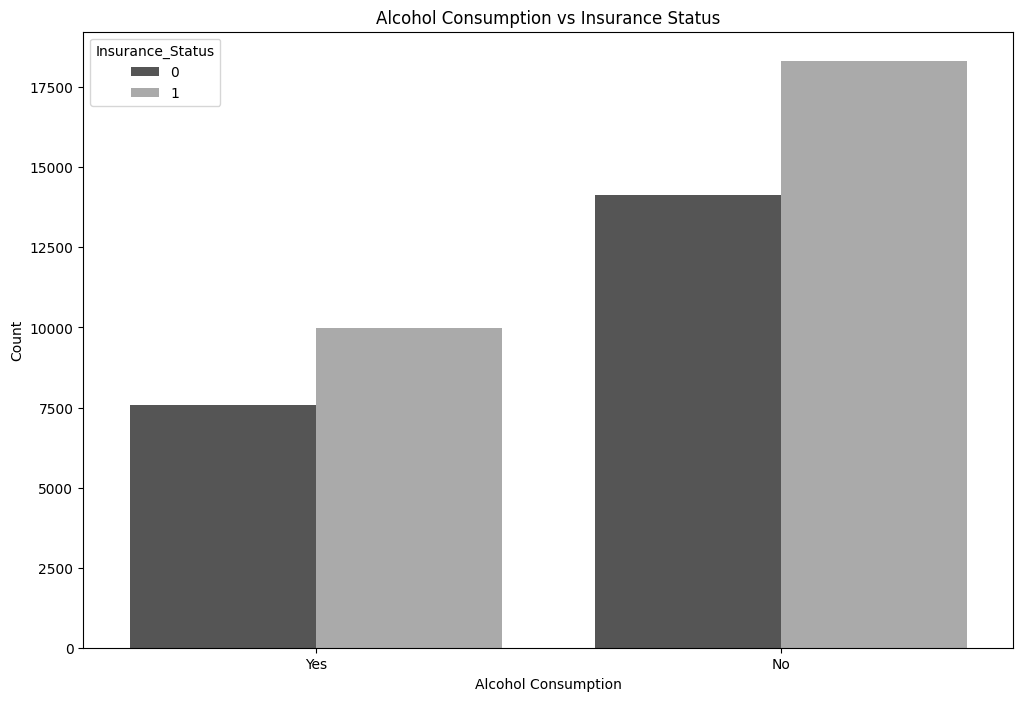

In [104]:
plt.figure(figsize=(12,8))
sns.countplot(x='Alcohol_Consumption',hue='Insurance_Status',data=df, palette='gray')
plt.title("Alcohol Consumption vs Insurance Status")
plt.xlabel("Alcohol Consumption")
plt.ylabel("Count")
plt.show()

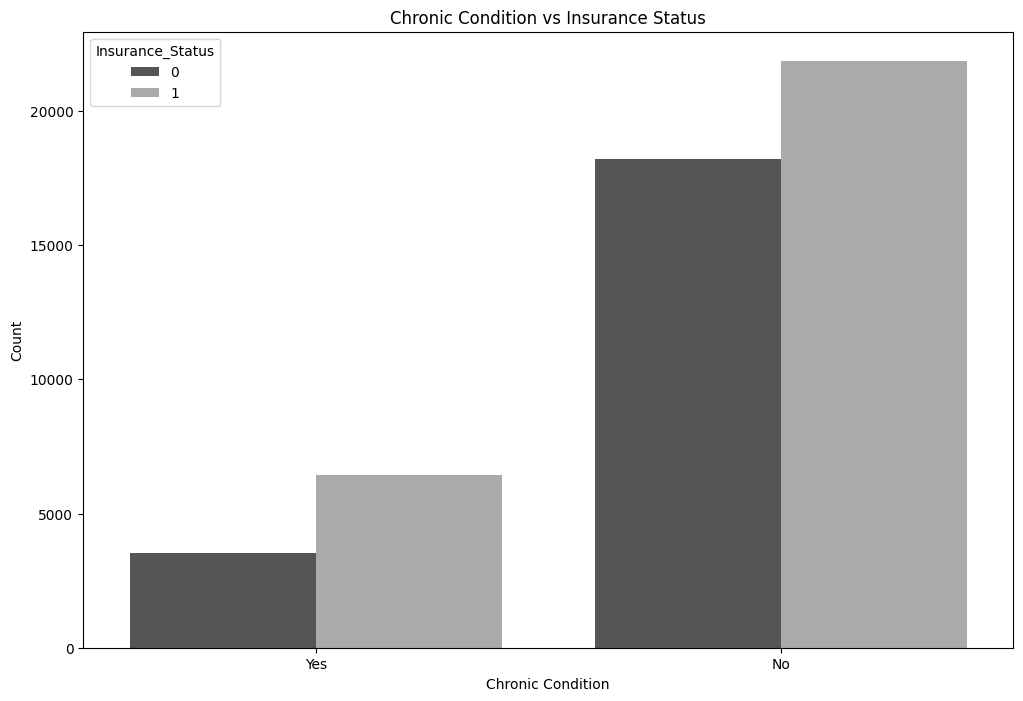

In [105]:
plt.figure(figsize=(12,8))
sns.countplot(x='Chronic_Condition',hue='Insurance_Status',data=df, palette='gray')
plt.title("Chronic Condition vs Insurance Status")
plt.xlabel("Chronic Condition")
plt.ylabel("Count")
plt.show()

In [106]:
exercise_table = pd.crosstab(df['Exercise'], df['Insurance_Status'])

chi2, p, dof, expected = chi2_contingency(exercise_table)

print("Exercise vs Insurance Status")
print("Chi-Square:", chi2)
print("p-value:", p)
if p < 0.05:
    print("Exercise habits significantly affect insurance status")
else:
    print("No significant effect of exercise habits on insurance status")

Exercise vs Insurance Status
Chi-Square: 0.0011423080280357329
p-value: 0.9730381927708875
No significant effect of exercise habits on insurance status


In [107]:
alcohol_table = pd.crosstab(df['Alcohol_Consumption'], df['Insurance_Status'])

chi2, p, dof, expected = chi2_contingency(alcohol_table)

print("Alcohol Consumption vs Insurance Status")
print("Chi-Square:", chi2)
print("p-value:", p)
if p < 0.05:
    print("Alcohol consumption significantly affects insurance status")
else:
    print("No significant effect of alcohol consumption on insurance status")

Alcohol Consumption vs Insurance Status
Chi-Square: 0.5630577593319231
p-value: 0.45303084183875897
No significant effect of alcohol consumption on insurance status


In [108]:
chronic_table = pd.crosstab(df['Chronic_Condition'], df['Insurance_Status'])

chi2, p, dof, expected = chi2_contingency(chronic_table)

print("Chronic Condition vs Insurance Status")
print("Chi-Square:", chi2)
print("p-value:", p)
if p < 0.05:
    print("Chronic condition significantly affects insurance status")
else:
    print("No significant effect of chronic condition on insurance status")

Chronic Condition vs Insurance Status
Chi-Square: 330.78803172530564
p-value: 6.473715470334021e-74
Chronic condition significantly affects insurance status


In [109]:
smoking_table = pd.crosstab(df['Smoking_Status'], df['Insurance_Status'])

chi2, p, dof, expected = chi2_contingency(smoking_table)

print("Smoking Status vs Insurance Status")
print("Chi-Square:", chi2)
print("p-value:", p)

if p < 0.05:
    print("Smoking status significantly affects insurance status")
else:
    print("No significant effect of smoking status on insurance status")


Smoking Status vs Insurance Status
Chi-Square: 1.8420453913579182
p-value: 0.17471140398097523
No significant effect of smoking status on insurance status


In [110]:
marital_table = pd.crosstab(df['Marital_Status'], df['Insurance_Status'])

chi2, p, dof, expected = chi2_contingency(marital_table)

print("Marital Status vs Insurance Status")
print("Chi-Square:", chi2)
print("p-value:", p)

if p < 0.05:
    print("Marital status significantly affects insurance status")
else:
    print("No significant effect of marital status on insurance status")


Marital Status vs Insurance Status
Chi-Square: 0.9712611677782418
p-value: 0.6153090704174005
No significant effect of marital status on insurance status


In [111]:
X = df.drop('Insurance_Status', axis=1)
y = df['Insurance_Status']

In [112]:
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()

In [113]:
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, num_cols),
    ('cat', categorical_pipeline, cat_cols)
])


In [114]:
model_pipeline = ImbPipeline(steps=[
    ('preprocessing', preprocessor),
    ('adasyn', ADASYN(random_state=42)),
    ('model', HistGradientBoostingClassifier(
        max_iter=300,
        learning_rate=0.05,
        max_depth=4,
        random_state=42
    ))
])

In [115]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [116]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Dependents',
                                                   'Income', 'Existing_Savings',
                                                   'Premium', 'Policy_Tenure',
                                                   'Claims_Count',
                                                   'Past_Claims_Amount', 'BMI',
                                                   'Income_Premium_Ratio',
                                                   'Claim_Frequency',
                                                   'Chronic_Condition_Num',
                                                   'Risk_...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Gender', 'Marital_Status',
                                                   'Location', 'Profession',
                                                   'Policy_Type',
                                                   'Smoking_Status',
                                                   'Chronic_Condition',
                                                   'Alcohol_Consumption',
                                                   'Exercise'])])),
                ('adasyn', ADASYN(random_state=42)),
                ('model',
                 HistGradientBoostingClassifier(learning_rate=0.05, max_depth=4,
                                                max_iter=300,
                                                random_state=42))])

In [117]:
y_proba = model_pipeline.predict_proba(X_test)[:, 1]

threshold = 0.55
y_pred = (y_proba > threshold).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5421
              precision    recall  f1-score   support

           0       0.48      0.53      0.50      4341
           1       0.61      0.55      0.58      5659

    accuracy                           0.54     10000
   macro avg       0.54      0.54      0.54     10000
weighted avg       0.55      0.54      0.54     10000



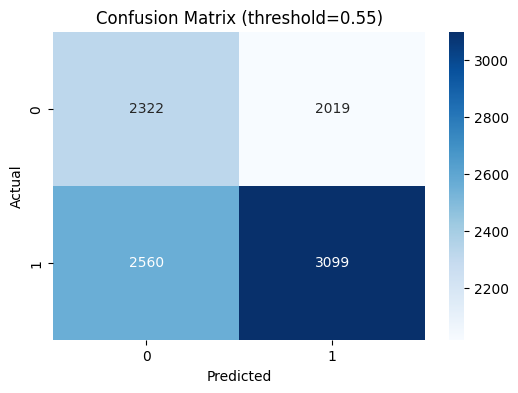

In [118]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (threshold={threshold})")
plt.show()

In [119]:
full_pipeline = model_pipeline.fit(X_train, y_train)

In [120]:
joblib.dump(full_pipeline, 'insurance_pipeline.pkl')
print("✅ Pipeline saved as 'insurance_pipeline.pkl'")

✅ Pipeline saved as 'insurance_pipeline.pkl'
